In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
# Function to load image
def load_image():
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
        return None, None

    filename = next(iter(uploaded))  # Get the uploaded file name
    print(f"Image '{filename}' uploaded successfully!")
    img = cv2.imread(filename)

    if img is None:
        print("Error: Failed to load the image. Please upload a valid image file.")
        return None, None

    return img, filename

In [135]:
# Function to detect if the image has low contrast
def detect_low_contrast(image, threshold=50):
    """Check if the image has low contrast based on histogram analysis."""
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_range = np.where(hist > 0)[0]  # Find non-zero histogram bins

    if len(hist_range) == 0:
        return False  # Empty image case
    contrast = hist_range[-1] - hist_range[0]
    print(f"Detected Contrast Range: {contrast}")
    return contrast < threshold

# Function to fix low contrast using adaptive thresholding
def fix_low_contrast(image):
    """Fix low contrast using adaptive thresholding."""
    print("Fixing low contrast...")
    img_thresholded = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111, 1
    )
    return img_thresholded


In [133]:
def detect_obstruction(image):
    """Detect obstructions dynamically using Otsu's thresholding."""

    # Apply Otsu's thresholding to dynamically determine the threshold value
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Check for obstructions by detecting large areas of foreground (pixels > threshold)
    # If there are large areas of white, we can assume there might be an obstruction
    obstruction_mask = thresholded_img == 255
    if np.any(obstruction_mask):
        print("Obstruction detected (dynamic thresholding).")
        return True

    print("No obstruction detected.")
    return False

def fix_obstruction(image, kernel_size=(150, 1)):
    """Fix obstruction by applying adaptive thresholding and morphological operations."""
    print("Fixing obstruction...")

    # Apply Otsu's thresholding to get an optimal threshold
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological opening (erosion followed by dilation) to remove small obstructions
    kernel = np.ones(kernel_size, np.uint8)

    # Opening to remove small unwanted noise (obstruction)
    #opened_image = cv2.morphologyEx(thresholded_img, cv2.MORPH_OPEN, kernel)

    # Optionally, you can apply morphological closing to fill small holes after removing obstructions
    closed_image = cv2.morphologyEx(thresholded_img, cv2.MORPH_CLOSE, kernel)

    return closed_image



In [106]:

def cropped_image(image):
  # Use Canny edge detection
    edges = cv2.Canny(image, 50, 150)
    # Detect vertical lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=197, maxLineGap=10)
    min_x, max_x, min_y, max_y = float('inf'), -float('inf'), float('inf'), -float('inf')

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Vertical lines: x1 == x2 or nearly vertical
            if abs(x1 - x2) < 10:
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)
            elif abs(y1 - y2) < 10:  # Horizontal lines
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)

    if min_x != float('inf') and max_x != -float('inf') and min_y != float('inf') and max_y != -float('inf'):
        return image[min_y:max_y, min_x:max_x]

Upload an Image...


Saving 10 - wen el kontraastttt.jpg to 10 - wen el kontraastttt (23).jpg
Image '10 - wen el kontraastttt (23).jpg' uploaded successfully!
Image loaded successfully!
Displaying Histogram of the Original Image...


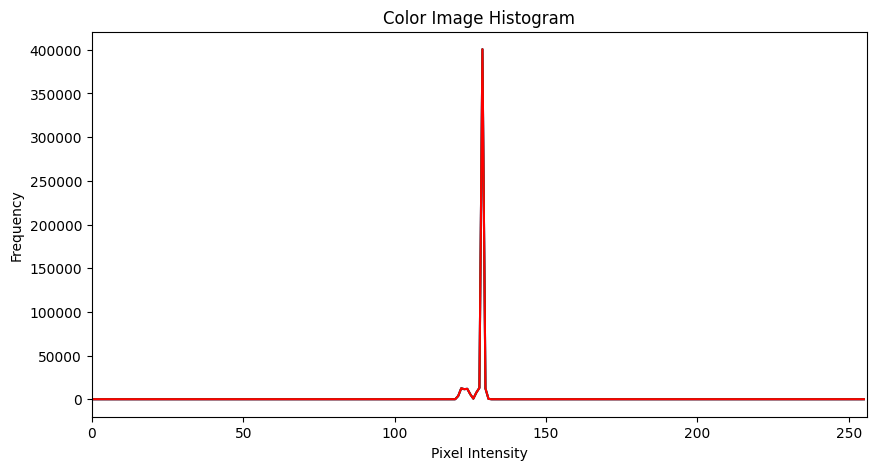

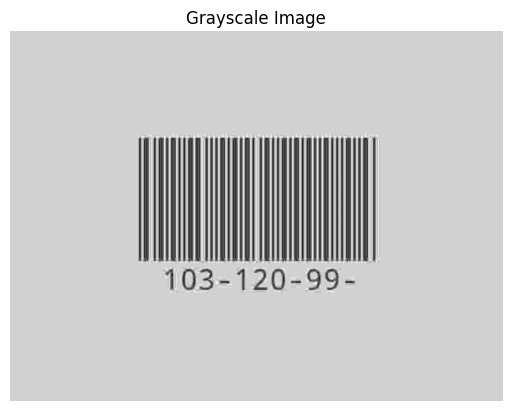

Displaying Histogram of the Grayscale Image...


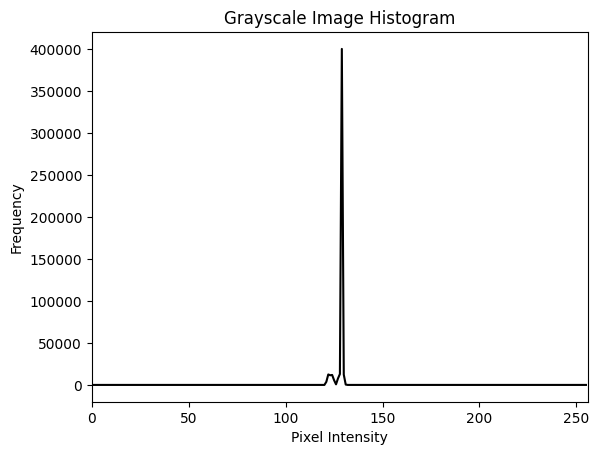

Detected Contrast Range: 11
Obstruction detected (dynamic thresholding).
Problem Detected: Obstruction
Fixing obstruction...
Displaying Histogram of the Binary Image...


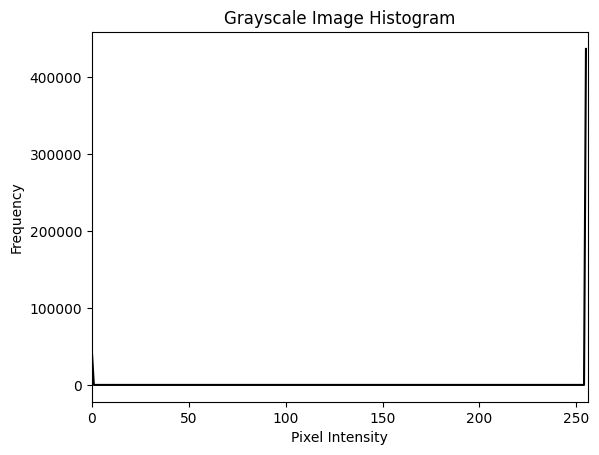

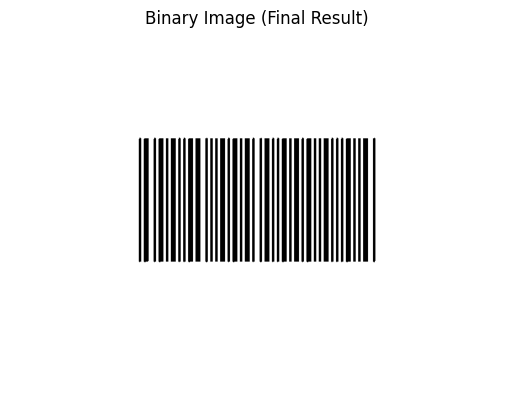

In [137]:
# Function to plot the histogram
def plot_histogram(image):
    """
    Plot the histogram of a grayscale or color image.
    For color images, the histogram is plotted for each channel (BGR).
    """
    # Check if the image is grayscale or color (BGR)
    if len(image.shape) == 2:  # Grayscale image
        # Compute histogram for a grayscale image
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        plt.plot(hist, color='black')
        plt.title("Grayscale Image Histogram")
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
    elif len(image.shape) == 3:  # Color image (BGR)
        colors = ('b', 'g', 'r')  # BGR channels
        plt.figure(figsize=(10, 5))
        plt.title("Color Image Histogram")
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')

        # Plot histogram for each channel (Blue, Green, and Red)
        for i, color in enumerate(colors):
            hist = cv2.calcHist([image], [i], None, [256], [0, 256])
            plt.plot(hist, color=color)

    plt.xlim(0, 256)  # Pixel intensity range (0-255)
    plt.show()

def enforce_binary(image):
    """
    Ensure the image has only 0 or 255 pixel values by applying a binary threshold.
    """
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary_image

# Updated Step 5 of the pipeline
def process_image():
    print("Upload an Image...")

    # Step 1: Upload and load the image
    img, filename = load_image()
    if img is None:
        return

    print("Image loaded successfully!")

    # Display the histogram of the original image
    print("Displaying Histogram of the Original Image...")
    plot_histogram(img)

    # Convert to Grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()

    # Display the histogram of the grayscale image
    print("Displaying Histogram of the Grayscale Image...")
    plot_histogram(img_gray)

    # Step 2: Detect the problem in the image
    is_low_contrast = detect_low_contrast(img_gray)
    is_obstructed = detect_obstruction(img_gray)

    # Step 3: Fix the detected problem
    if is_obstructed:
        print("Problem Detected: Obstruction")
        fixed_img = fix_obstruction(img_gray)
    elif is_low_contrast:
        print("Problem Detected: Low Contrast")
        fixed_img = fix_low_contrast(img_gray)
    else:
        print("No Major Problem Detected, Proceeding with Original Image")
        fixed_img = img_gray

    # Step 4: Enforce binary values (0 or 255)
    binary_img = enforce_binary(fixed_img)

    # Display the histogram of the processed binary image
    print("Displaying Histogram of the Binary Image...")
    plot_histogram(binary_img)

    # Step 5: Display Results
    plt.imshow(binary_img, cmap='gray')
    plt.title("Binary Image (Final Result)")
    plt.axis('off')
    plt.show()

# Run the updated pipeline
process_image()


Upload an Image...


Saving 06 - meen fata7 el nour 333eenaaayy.jpg to 06 - meen fata7 el nour 333eenaaayy.jpg
Image '06 - meen fata7 el nour 333eenaaayy.jpg' uploaded successfully!
Image loaded successfully!


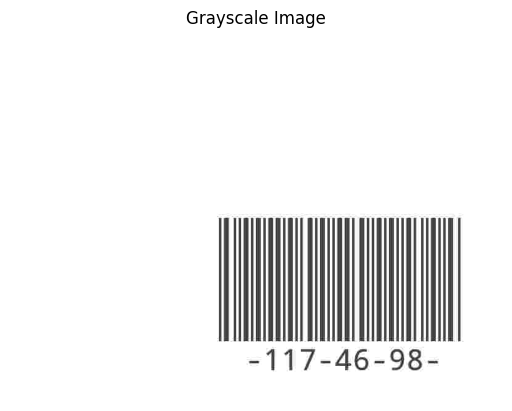

Detected Contrast Range: 19
Obstruction detected (dynamic thresholding).
Problem Detected: Obstruction
Fixing obstruction...


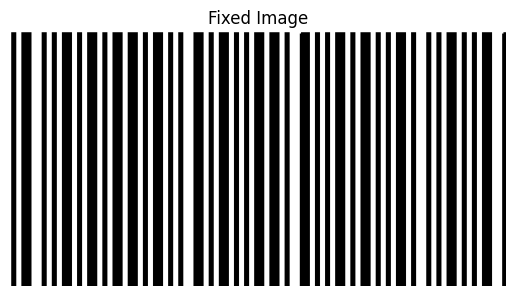

In [144]:
# normal main Processing Pipeline
def process_image():
    print("Upload an Image...")

    # Step 1: Upload and load the image
    img, filename = load_image()
    if img is None:
        return

    print("Image loaded successfully!")

    # Convert to Grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()


    # Step 2: Detect the problem in the cropped image
    is_low_contrast = detect_low_contrast(img_gray)
    is_obstructed = detect_obstruction(img_gray)

    # Step 3: Choose the pipeline based on the problem
    if is_obstructed:
        print("Problem Detected: Obstruction")
        fixed_img = fix_obstruction(img_gray)
    elif is_low_contrast:
        print("Problem Detected: Low Contrast")
        fixed_img = fix_low_contrast(img_gray)
    else:
        print("No Major Problem Detected, Proceeding with Original Image")
        fixed_img = img_gray

    # Step 4: Crop the image first to focus on the barcode region
    final_img_cropped_barcode = cropped_image(fixed_img)


    # Step 5: Display Results
    plt.imshow(final_img_cropped_barcode, cmap='gray')
    plt.title("Fixed Image")
    plt.axis('off')

    plt.show()


# Run the pipeline
process_image()
